In [1]:
import json
import os
import mimetypes

import pandas as pd

from plot_from_dict import *

In [2]:
%cd ..
%pwd

/home/onyxia/work/ML_research_seminar


'/home/onyxia/work/ML_research_seminar'

# I. Preparation of the data

In [3]:
list_dict = []

path_results = "./model/results/"

with os.scandir(path_results) as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(f"{path_results}/{name}", 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [4]:
path_homophily = "./homophily/homophily_data.csv"

df_homophily = pd.read_csv(path_homophily)
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Size_dataset,Nb_class,Nb_features,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,188,2,7,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,600,6,3,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,1113,2,3,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,10000,2,3,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,10000,6,7,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [5]:
for dic in list_dict :
  name_dataset = dic["dataset"]
  dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]

# II. Scatter plot in 3D

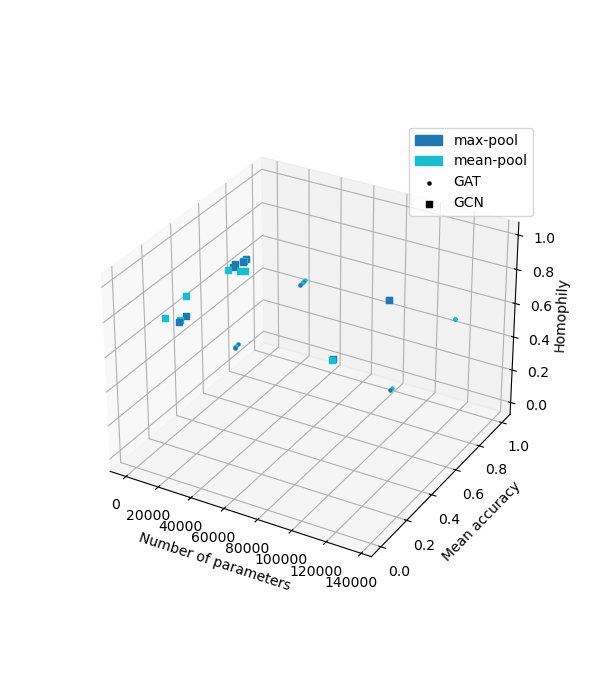

In [6]:
%matplotlib widget
plot_from_dict(list_dict, (6,7))

# III. Pairplot

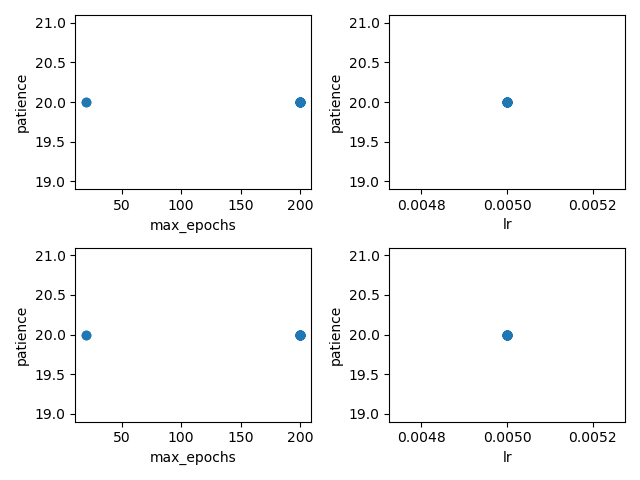

In [8]:
pairplot_from_dict(list_dict, [('max_epochs','patience'),('lr','patience'),('max_epochs','patience'),('lr','patience')], (2,2))

# IV Losses

In [6]:
list_dict[0].keys()

dict_keys(['alpha', 'attention_heads', 'batch_size', 'convolution_layer', 'dataset', 'deterministic_algorithms', 'global_pooling_layer', 'local_pooling_layer', 'lr', 'max_epochs', 'patience', 'split 1', 'split 2', 'split 3', 'split 4', 'split 5', 'split 6', 'split 7', 'split 8', 'split 9', 'split 10', 'nb_parameters', 'mean_accuracy', 'std_accuracy', 'homophily'])

In [7]:
plot_losses(list_dict, "train")

In [8]:
plot_losses(list_dict, "val")

In [10]:
plot_acc(list_dict, "train")

In [11]:
plot_acc(list_dict, "val")

In [6]:
plot_acc_and_loss(list_dict, "train")

In [7]:
plot_acc_and_loss(list_dict, "val")

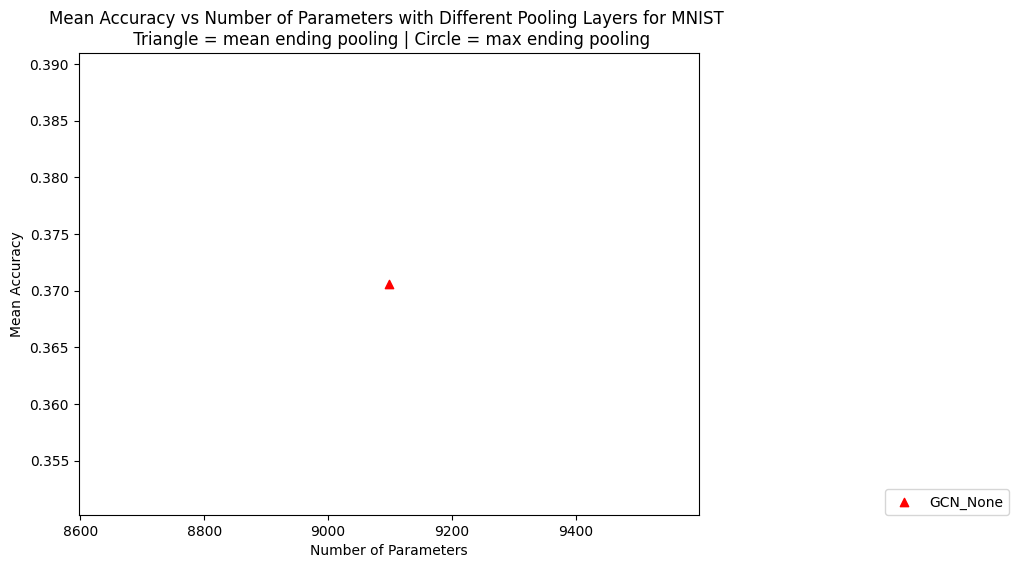

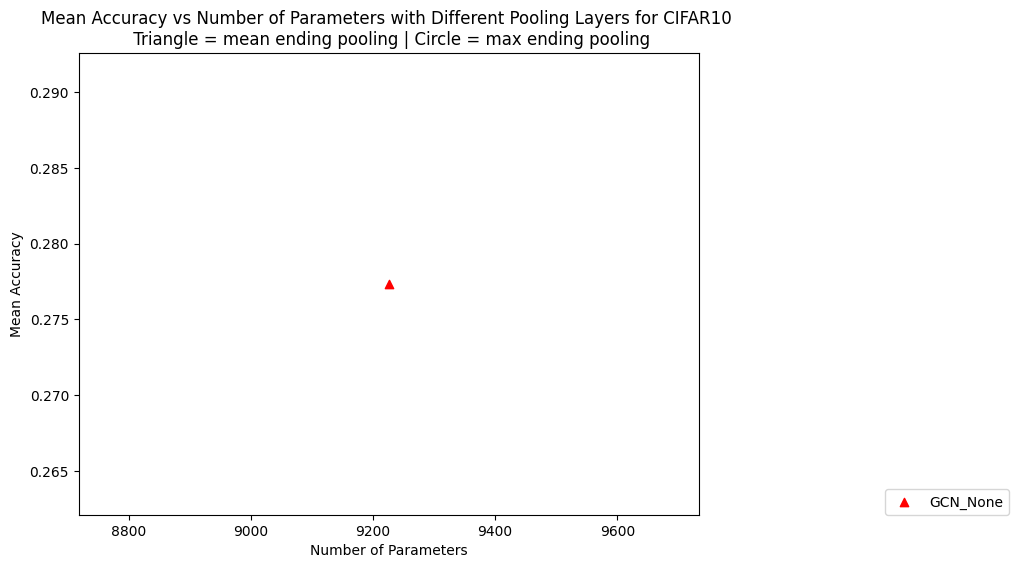

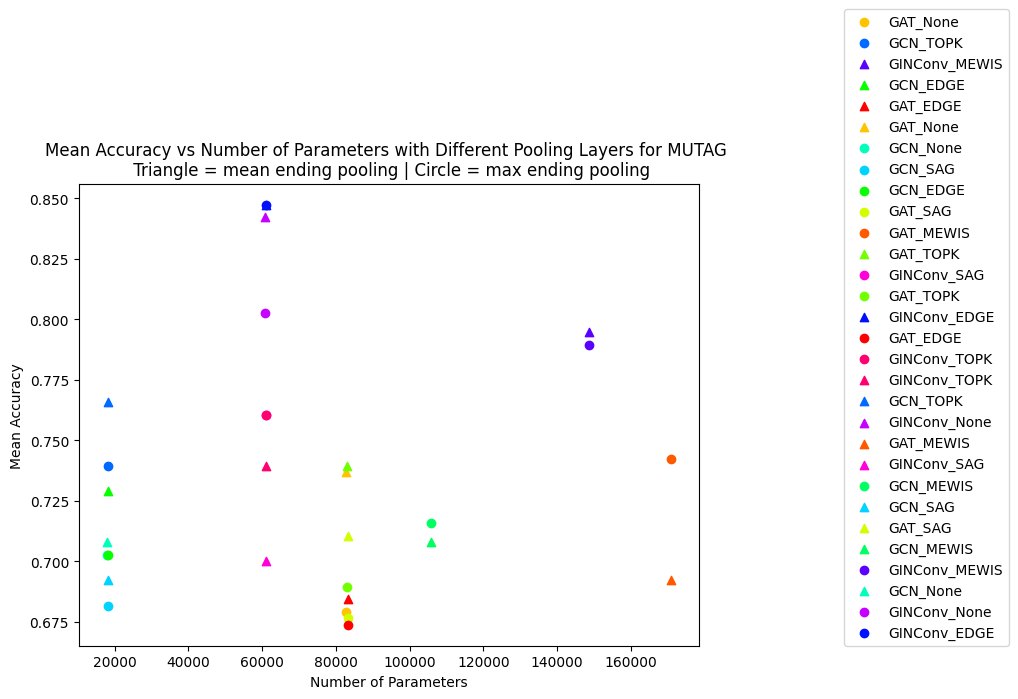

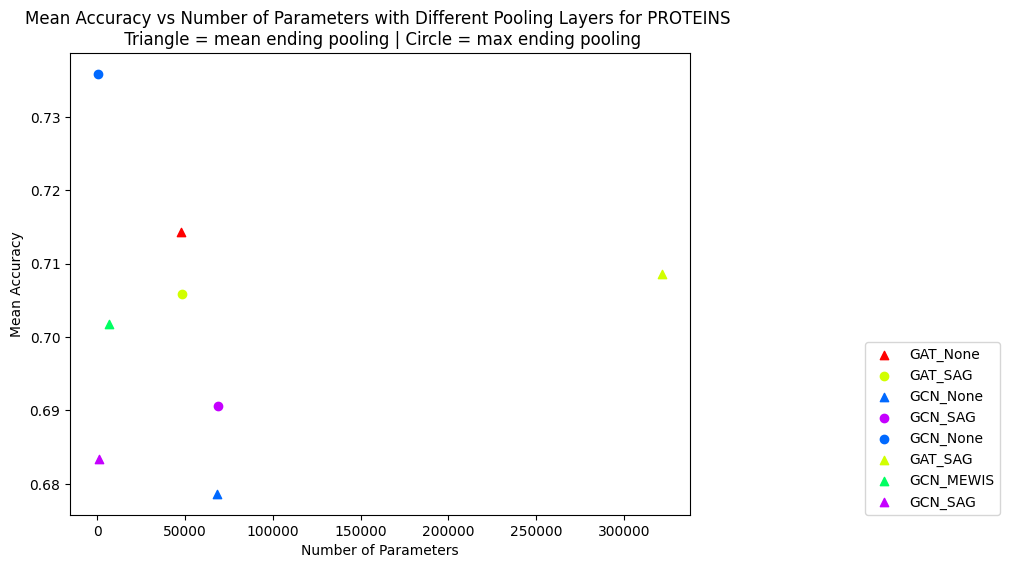

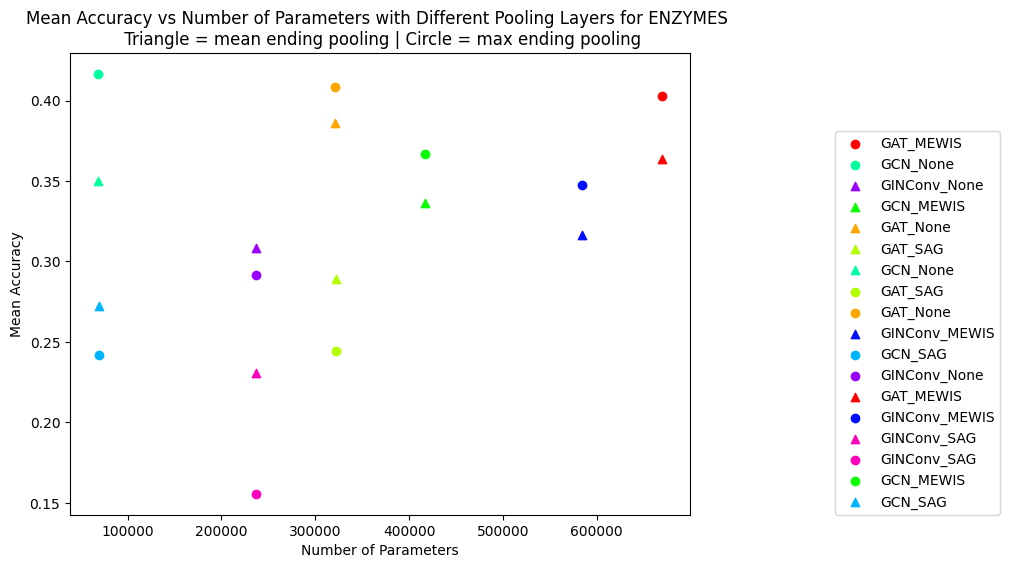

In [6]:
plot_acc_parameters(list_dict)